In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
fns = [os.path.join('data', fn) for fn in os.listdir('data')]
fns_training = list(filter(lambda x: 'data_batch' in x, fns))
data = [unpickle(fn) for fn in fns_training]
fns_test = list(filter(lambda x: 'test_batch' in x, fns))
data_test = [unpickle(fn) for fn in fns_test]

In [11]:

# lets split the data into training, validation and test
X = np.concatenate([data[i][b'data'] for i in range(len(data))], axis=0)
Y = np.concatenate([data[i][b'labels'] for i in range(len(data))], axis=0)
Xtr = torch.tensor(X[0:45000, :], dtype=torch.float32)
Ytr = torch.tensor(Y[0:45000])
Xdev = torch.tensor(X[45000:50000, :], dtype=torch.float32)
Ydev = torch.tensor(Y[45000:50000])
Xtest = torch.tensor(np.concatenate([data_test[i][b'data'] for i in range(len(data_test))], axis=0))
Ytest = torch.tensor(np.concatenate([data_test[i][b'labels'] for i in range(len(data_test))], axis=0))
# lets normalize the data
# Xtr = (Xtr - Xtr.mean(dim=1, keepdim=True)) / 127.0
# Xdev -= (Xdev - Xdev.mean(dim=1, keepdim=True)) / 127.0

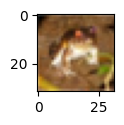

In [34]:
Xtr_conv = Xtr.view(45000, 3, 32, 32)
img = Xtr_conv[0].numpy().astype(int)
img = np.rollaxis(img, 0, 3)
plt.figure(figsize=(1,1))
plt.imshow(img)

In [31]:
class NeuralNetwork(nn.Module):
        def __init__(self):
                super().__init__()
                self.mlp = nn.Sequential(
                        nn.Linear(3072, 50), nn.Tanh(),
                        nn.Linear(50, 50), nn.Tanh(),
                        nn.Linear(50, 10)
                )

        def forward(self, x):
                logits = self.mlp(x)
                return logits

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
lossi = [] 

model_conv = ConvNet()

In [38]:
for i in range(20000):
    #mini batch
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # Xb, Yb = Xtr[ix], Ytr[ix]
    Xb_conv, Yb_conv = Xtr_conv[ix], Ytr[ix]
    #forward pass
    logits = model_conv(Xb_conv)
    loss = F.cross_entropy(logits, Yb_conv)
    #backward pass
    optimizer.zero_grad()  
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

    if i % 1000 == 0:
        print(loss)



tensor(4.7319, grad_fn=<NllLossBackward0>)
tensor(4.5600, grad_fn=<NllLossBackward0>)
tensor(4.0347, grad_fn=<NllLossBackward0>)
tensor(3.7499, grad_fn=<NllLossBackward0>)
tensor(4.5308, grad_fn=<NllLossBackward0>)
tensor(4.6241, grad_fn=<NllLossBackward0>)
tensor(4.2635, grad_fn=<NllLossBackward0>)
tensor(4.2513, grad_fn=<NllLossBackward0>)
tensor(4.3659, grad_fn=<NllLossBackward0>)
tensor(4.6750, grad_fn=<NllLossBackward0>)
tensor(4.4988, grad_fn=<NllLossBackward0>)
tensor(4.5846, grad_fn=<NllLossBackward0>)
tensor(4.7782, grad_fn=<NllLossBackward0>)
tensor(4.0676, grad_fn=<NllLossBackward0>)
tensor(3.6149, grad_fn=<NllLossBackward0>)
tensor(4.1167, grad_fn=<NllLossBackward0>)
tensor(4.5766, grad_fn=<NllLossBackward0>)
tensor(3.8984, grad_fn=<NllLossBackward0>)
tensor(3.9661, grad_fn=<NllLossBackward0>)
tensor(4.4687, grad_fn=<NllLossBackward0>)


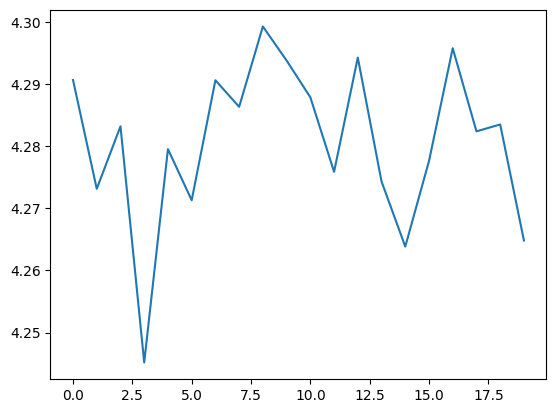

In [39]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [152]:
model.eval()
logits = model(Xdev)
loss_dev = F.cross_entropy(logits, Ydev)
print(f"Training Loss = {loss}, Dev Loss = {loss_dev}")
probs = F.softmax(logits, dim=1)
ypred = torch.multinomial(probs, num_samples=1).view(-1)
sum(ypred == Ydev)/len(Ydev)


Training Loss = 1.4801307916641235, Dev Loss = 1.9026992321014404


tensor(0.2798)

In [68]:
ypred.shape

torch.Size([5000, 1])